In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import save_model, load_model

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Don't forget to import patches

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
import pickle
import ast
import cv2

from glob import glob
from PIL import Image
from tqdm import tqdm

2023-08-23 16:46:37.557709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:46:37.753600: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 16:46:37.802598: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2023-08-23 16:46:38.748118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-23 16:46:38.748202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-23 16:46:38.748212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.10.0


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
# Configuration
SEP = " -<>- "
IMG_SIZE = 299
MAX_LENGTH = 45


PATH = "/home/fabricio/projeto/BarchartReverseEngineering/dataset/train_synthetic_simple"
IMG_PATH = PATH + "/plots/"
BARS_PATH = PATH + "/train_synthetic_simple_barbbox.idl"
IMGSIZE_PATH = PATH + "/train_synthetic_simple_imgsize.idl"

START_TOKEN = [1.0, 1.0, 0.0] 
END_TOKEN = [0.0, 0.0, 0.0]

In [5]:
# utilities

def get_normalized_data(bbox, real_imgsize):
    '''
    return bar's center coordinate and height

    Parameters:
    bbox (list): [x1, y1, x2, y2]
    real_imgsize (tuple): (imgsize, bar_direction)
    '''

    imgsize, bar_direction = real_imgsize

    x_m = ((bbox[2] + bbox[0])/2)/imgsize[0]
    y_m = ((bbox[3] + bbox[1])/2)/imgsize[1]

    # top-left and bottom-right x coordinates divided by image width
    bbox[0] /= imgsize[0]
    bbox[2] /= imgsize[0]
    # top-left and bottom-right y coordinates divided by image height
    bbox[1] /= imgsize[1]
    bbox[3] /= imgsize[1]


    # normalized height
    if bar_direction == "vertical":
        height = abs(bbox[3] - bbox[1])
        result = [x_m, y_m, height]
    else:
        height = abs(bbox[2] - bbox[0])
        result = [x_m, y_m, height]

    return result


# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (299, 299))
#     img = tf.keras.applications.xception.preprocess_input(img)

#     img_np = img.numpy()  # Convert tensor to NumPy array
#     img_dilated = cv2.dilate(img_np, np.ones((3, 3), np.uint8), iterations=1)
#     img_eroded = cv2.erode(img_dilated, np.ones((3, 3), np.uint8), iterations=1)
#     img_tensor = tf.convert_to_tensor(img_eroded, dtype=tf.float32)  # Convert NumPy array back to tensor
#     return img_tensor, image_path

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [6]:
Image = load_image('dataset/test_synthetic/plots/test_synthetic_0.png')

2023-08-23 16:46:40.227682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:46:42.890970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22832 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:15:00.0, compute capability: 7.5
2023-08-23 16:46:42.891816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14006 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:2d:00.0, compute capability: 7.5


In [7]:
all_bars = []
all_img_name_vector = []

with open(BARS_PATH, "r") as fbar, open(IMGSIZE_PATH, "r") as fsize:
    # fsize is the file that contains the image size
    # fbar is the file that contains the bar's bounding box

    for bars, imgsize in tqdm(zip(fbar, fsize)):
        bars = bars.strip() #remove \n
        imgsize = imgsize.strip() #remove \n
        bars = bars.split(SEP) # split by separator
        imgsize = imgsize.split(SEP) # split by separator
        assert bars[0] == imgsize[0], "image name not match!" # check if the image name is the same
        
        all_img_name_vector.append(IMG_PATH + bars[0]) # add image path to the vector
        boxs = ast.literal_eval(bars[1]) # convert string to list
        imgsize = ast.literal_eval(imgsize[1]) # convert string to tuple
        one_img_bar = [START_TOKEN] # start-token 
        
        for box in boxs:
            bbox = box["bbox"]
            bar_info = get_normalized_data(bbox, imgsize)
            one_img_bar.append(bar_info)
        one_img_bar.append(END_TOKEN) # end-token
        # padding the sequence
        if len(one_img_bar) < MAX_LENGTH + 2:
            need = MAX_LENGTH + 2 - len(one_img_bar)
            for i in range(need):
                one_img_bar.append(END_TOKEN)
        
        all_bars.append(one_img_bar)

bars_vector, img_name_vector = shuffle(all_bars, all_img_name_vector, random_state=1)

6it [00:00, 50.30it/s]

30000it [00:03, 9398.90it/s] 


First value: Y coordinate of the center of the bar.

Second value: X-coordinate of the center of the bar.

Third value: Normalized bar height.

In [8]:
# *** unit test section ***
print(len(bars_vector[0]), len(img_name_vector[0]))
print(bars_vector[0])
print(img_name_vector[0])

47 119
[[1.0, 1.0, 0.0], [0.36036036036036034, 0.23423423423423423, 0.45045045045045046], [0.4988738738738739, 0.5180180180180181, 0.7274774774774775], [0.3108108108108108, 0.8018018018018018, 0.35135135135135137], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
/home/fabricio/projeto/BarchartReverseEngineering/data

In [9]:
print(len(img_name_vector), len(bars_vector))

30000 30000


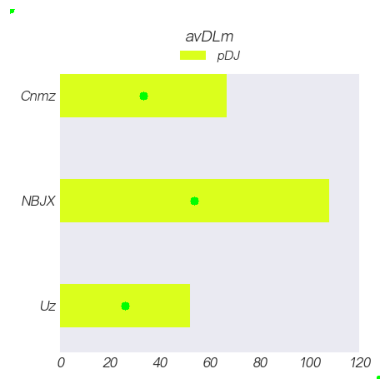

In [10]:
img = cv2.imread("dataset/train_synthetic_simple/plots/train_synthetic_simple_10747.png")

for i in range(len(bars_vector[0])):
    x = int(bars_vector[0][i][0] * img.shape[1])
    y = int(bars_vector[0][i][1] * img.shape[0])
    cv2.circle(img, (x, y), 5, (0, 255, 0), -1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
max_length = MAX_LENGTH + 2

# higher some data just to test the model
# img_name_vector = img_name_vector[:int(len(img_name_vector) * 1/50)]
# bars_vector = bars_vector[:int(len(bars_vector) * 1/50)]

# Create training and validation sets
img_name_train, img_name_val, bar_train, bar_val = train_test_split(img_name_vector, bars_vector, test_size=0.04, random_state=0)

In [12]:
len(img_name_train), len(bar_train), len(img_name_val), len(bar_val)

(28800, 28800, 1200, 1200)

In [13]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
barinfo_size = 3
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [14]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor, _ = load_image(img_name)
    return img_tensor, cap

In [15]:
# create tf dataset object 
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, bar_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.float32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Attention Model

This class implements the Bahdanau attention mechanism, which is used to calculate attention weights in a neural translation model called Seq2Seq. Bahdanau attention is a form of alignment-based attention that allows the model to focus on different parts of the input while generating the output. In this specific case, the attention is applied to input features generated by a CNN encoder layer.

In [16]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    # units: dimension of the hidden layer
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features: CNN_encoder output
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden: hidden state of the RNN_decoder (last state)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    #print("feature:", features.shape)
    #print("hidden:", hidden_with_time_axis.shape)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context:", context_vector.shape)

    return context_vector, attention_weights

### Encoder

This class represents a CNN encoder. It is used to extract features from an input image. It has a pre-trained convolutional neural network (CNN) layer, which is used to extract features from the image. The extracted features are then passed through a dense (fully connected) layer to properly scale them.

In [17]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

        # load the pre-trained model      
        image_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', pooling=None)
        new_input = image_model.input
        hidden_layer = image_model.output

        # receive the input and output of the pre-trained model
        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
        L = len(self.image_features_extract_model.layers)
        
        # last 10 layers are trainable, others are not trainable
        for i, layer in enumerate(self.image_features_extract_model.layers):
          if i < L - 10:
            layer.trainable = False
          else:
            layer.trainable = True

    def call(self, x):
        x = self.image_features_extract_model(x)
        x = tf.reshape(x, [x.shape[0], -1, x.shape[-1]]) # (batch_size, 64, embedding_dim)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Decoder

This class is responsible for decoding in a Seq2Seq model. It uses an RNN decoder layer (in this case, a GRU layer) to generate the output sequence based on the input features and the hidden state from the previous decoder step. It also uses the Bahdanau attention mechanism to weight the input features according to their relative importance at each decoding step.

In [18]:
class RNN_Decoder(tf.keras.Model):
  # RNN_decoder: LSTM
  # embedding_dim: dimension of the embedding layer
  # units: dimension of the hidden layer
  # barinfo_size: dimension of the bar information
  def __init__(self, embedding_dim, units, barinfo_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    # embedding layer to transform the input into a vector of dimension embedding_dim 
    self.embedding = tf.keras.layers.Dense(embedding_dim, activation="relu")
    # GRU: a type of RNN
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units, activation="relu")
    self.fc2 = tf.keras.layers.Dense(barinfo_size, activation="relu")

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, state):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, state)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    # Concatenate the input vector x with the context vector to incorporate relevant information from both the previous bar and the attention-based context. 
    # This allows the decoder to consider both the local information (previous bar) and the global context (graph features) when generating the next bar information.  
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    #print("x:", x.shape)
    #output: a batch of sequences of vectors of dimension units
    #state: the last hidden state of the GRU
    output, state= self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [19]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, barinfo_size)

In [20]:
# Define the optimizer and the loss function

# learning rate decay schedule (exponential decay)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=500, decay_rate=0.96, staircase=True)

# update the weights of the model using the stochastic gradient descent (SGD) optimizer
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
#optimizer = tf.keras.optimizers.RMSprop()

# loss function
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

========================================================================================================

In [21]:
checkpoint_path = "model/model_checkpoint_simple"

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [22]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"Restoring from previous step {start_epoch} ...")
else:
    print("Training from scratch ...")

Restoring from previous step 375 ...


========================================================================================================

In [23]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [24]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initializing the hidden state for each batch
    # Because the target is not related from image to image
    state = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([START_TOKEN] * BATCH_SIZE, 1)

    # Gradient
    with tf.GradientTape() as tape:
        # Getting the output from the encoder
        features = encoder(img_tensor)  # (batch_size, 64, embedding_dim)
        # For each bar in the target sequence
        for i in range(1, target.shape[1]):
            # Passing the features through the decoder
            predictions, state, _ = decoder(dec_input, features, state)
            loss += loss_function(target[:, i], predictions)

            # Using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    # Averaging the loss
    total_loss = (loss / int(target.shape[1]))

    # Getting the trainable variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Calculating the gradients
    gradients = tape.gradient(loss, trainable_variables)

    # Updating the weights
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [25]:
EPOCHS = 1000

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.8f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.8f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2023-08-23 16:47:52.763228: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


Epoch 376 Batch 0 Loss 0.00000010


KeyboardInterrupt: 

In [ ]:
loss_plot

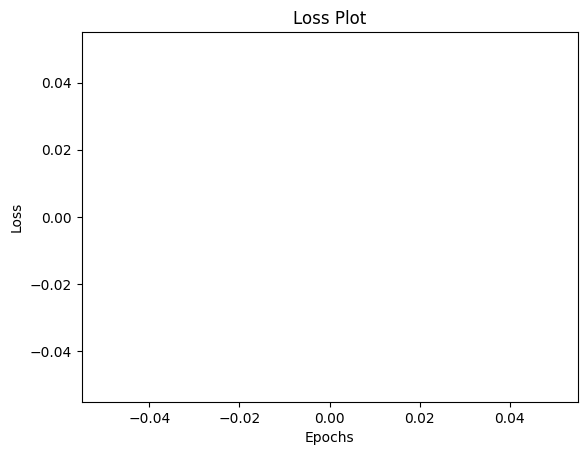

In [26]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [27]:
def evaluate(image):
    # Initialize the attention plot matrix
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Reset the hidden state of the decoder for each evaluation
    hidden = decoder.reset_state(batch_size=1)

    # Preprocess the image and extract relevant features using the encoder
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    features = encoder(temp_input)

    # Set the initial input for the decoder as the start token
    dec_input = tf.expand_dims([START_TOKEN], 0)
    result = []

    loss = 0
    # Generate predictions and attention weights for each step up to the maximum length
    # max_length is the maximum length of the target sentence
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # calculate error
        loss += loss_function(dec_input, predictions)

        # Store the attention weights in the attention plot matrix
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Convert the predictions to a numpy array
        predictions = predictions.numpy()

        # Check if the sum of predictions is below a threshold to end the sequence
        if np.sum(predictions[0]) < 0.1:
            break
            
        # Append the predictions to the result list
        result.append(predictions[0])

        # Update the decoder input with the predictions for the next step
        dec_input = tf.expand_dims(predictions, 0)

    # Trim the attention plot matrix to match the length of the result list
    attention_plot = attention_plot[:len(result), :]

    # Return the result list and the attention plot matrix
    return result, attention_plot


## Predictions

In [28]:
# extractions on the validation set
image = img_name_val[4]
target = bar_val[4]
print(image)
print(target)

result, attention_plot = evaluate(image)

/home/fabricio/projeto/BarchartReverseEngineering/dataset/train_synthetic_simple/plots/train_synthetic_simple_16055.png
[[1.0, 1.0, 0.0], [0.3658008658008658, 0.44155844155844154, 0.7272727272727273], [0.8636363636363636, 0.735621521335807, 0.13914656771799638], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 

In [29]:
print('Real: ', target)
print('Pred: ', result)

Real:  [[1.0, 1.0, 0.0], [0.3658008658008658, 0.44155844155844154, 0.7272727272727273], [0.8636363636363636, 0.735621521335807, 0.13914656771799638], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
Pred:  [array([0.3617667 , 0.44248122, 0.7313392 ], dtype=float32), array([0.8608296 , 0.7379192 , 0.1

## Attention

In [30]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(15, 15))

    fname = os.path.basename(image)
    np.save(fname, attention_plot)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (10, 10))
        temp_att = cv2.GaussianBlur(temp_att, (3, 3), 0)
        ax = fig.add_subplot(len_result, 1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [31]:
plot_attention(image, result, attention_plot)
# opening the image
#Image.open(img_name_train[rid])

AttributeError: 'tuple' object has no attribute 'open'

In [32]:

def plot_lines_on_image(pred, image_path, direction, target=None, save=None, path=None):
    # Load the image
    image = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot the lines on the image using the "Pred" values
    for center_width in pred:
        center_x, center_y, width = center_width

        # Assuming center_x and center_y are in the range [0, 1], we can convert them to pixel coordinates
        x = center_x * image.shape[1]
        y = center_y * image.shape[0]

        # Calculate the coordinates of the two endpoints of the line based on the direction
        if direction == 'horizontal':
            w = width * image.shape[1]
            x1 = x - w / 2
            x2 = x + w / 2
            y1 = y
            y2 = y
        elif direction == 'vertical':
            w = width * image.shape[0]
            x1 = x
            x2 = x
            y1 = y - w / 2
            y2 = y + w / 2
        else:
            raise ValueError("Invalid direction. Use 'horizontal' or 'vertical'.")

        # Plot the line using the endpoints
        ax.plot([x1, x2], [y1, y2], color='r', linewidth=1)

        # Add a circle at the center
        ax.plot(x, y, marker='o', markersize=5, color='g')

    if target is not None:
        for center_width in target:
            center_x, center_y, width = center_width

            # Assuming center_x and center_y are in the range [0, 1], we can convert them to pixel coordinates
            x = center_x * image.shape[1]
            y = center_y * image.shape[0]

            # Calculate the coordinates of the two endpoints of the line based on the direction
            if direction == 'horizontal':
                w = width * image.shape[1]
                x1 = x - w / 2
                x2 = x + w / 2
                y1 = y
                y2 = y
            elif direction == 'vertical':
                w = width * image.shape[0]
                x1 = x
                x2 = x
                y1 = y - w / 2
                y2 = y + w / 2
            else:
                raise ValueError("Invalid direction. Use 'horizontal' or 'vertical'.")

            # Plot the line using the endpoints
            ax.plot([x1, x2], [y1, y2], color='g', linewidth=1)

            # Add a circle at the center
            ax.plot(x, y, marker='o', markersize=3, color='b')

    if save:
        plt.savefig(path)

    # Show the plot with the image and lines
    plt.show()

    

# plot_lines_on_image(result, '/home/fabricio/projeto/BarchartReverseEngineering/dataset/train/plots/train_6508.png', 'vertical')

## Barras synthetic

In [33]:
BARS_PATH = "dataset/test_synthetic_simple/test_synthetic_simple_barbbox.idl"
IMGSIZE_PATH = "dataset/test_synthetic_simple/test_synthetic_simple_imgsize.idl"
IMG_PATH = "dataset/test_synthetic_simple/plots/"

all_bars = [] # target
all_bar_direction = [] # plot
all_img_name_vector = [] # source

with open(BARS_PATH, "r") as fbar, open(IMGSIZE_PATH, "r") as fsize:
    # fsize is the file that contains the image size
    # fbar is the file that contains the bar's bounding box
    for bars, imgsize in tqdm(zip(fbar, fsize)):
        bars = bars.strip() #remove \n
        imgsize = imgsize.strip() #remove \n
        bars = bars.split(SEP) # split by separator
        imgsize = imgsize.split(SEP) # split by separator
        assert bars[0] == imgsize[0], "image name not match!" # check if the image name is the same
        
        all_img_name_vector.append(IMG_PATH + bars[0]) # add image path to the vector
        boxs = ast.literal_eval(bars[1]) # convert string to list
        imgsize = ast.literal_eval(imgsize[1]) # convert string to tuple
        one_img_bar = [START_TOKEN] # start-token 
        
        for box in boxs:
            bbox = box["bbox"]
            bar_info = get_normalized_data(bbox, imgsize)
            one_img_bar.append(bar_info)
        one_img_bar.append(END_TOKEN) # end-token
        # padding the sequence
        if len(one_img_bar) < MAX_LENGTH + 2:
            need = MAX_LENGTH + 2 - len(one_img_bar)
            for i in range(need):
                one_img_bar.append(END_TOKEN)
        
        all_bars.append(one_img_bar)
        all_bar_direction.append(imgsize[1])

bars_test, img_name_test, bars_direction_test = shuffle(all_bars, all_img_name_vector, all_bar_direction, random_state=1)

150it [00:00, 3433.53it/s]


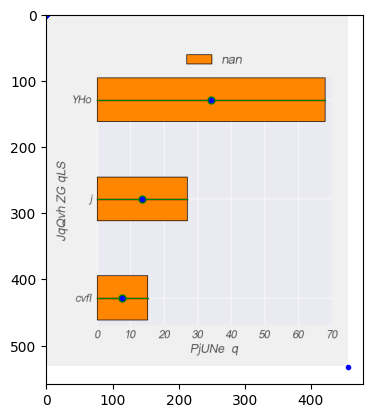

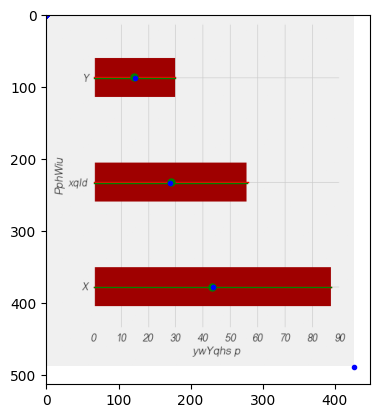

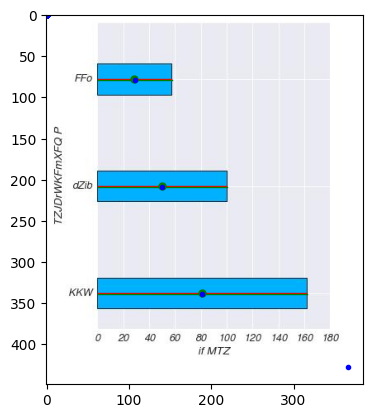

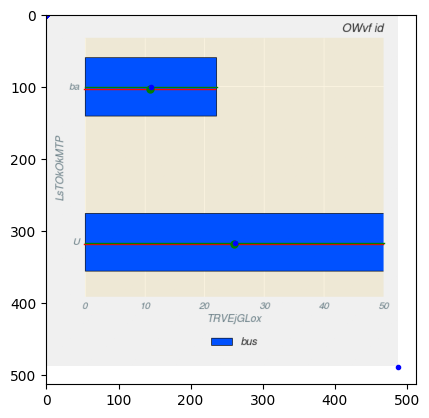

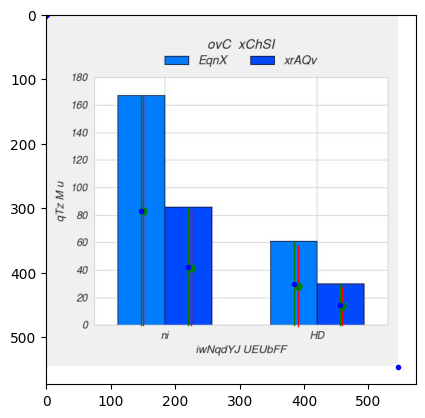

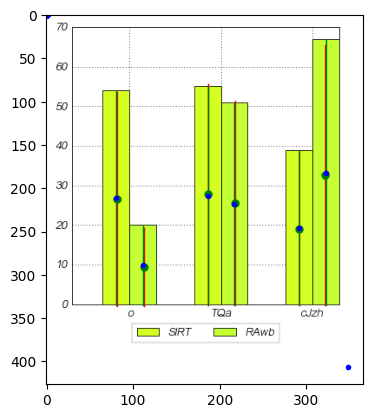

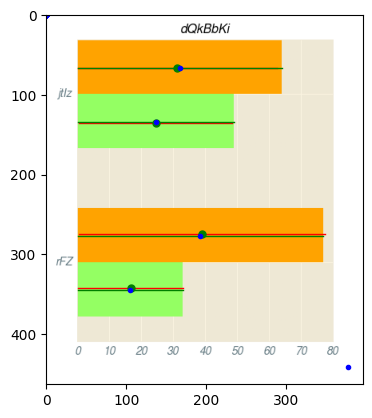

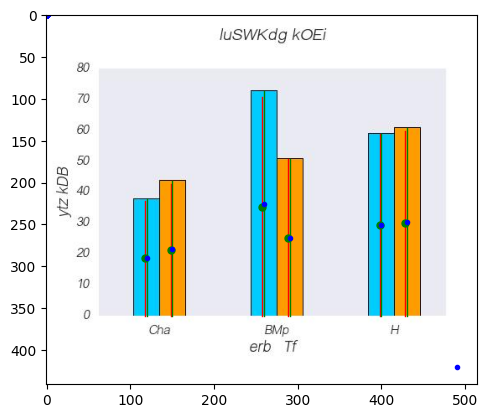

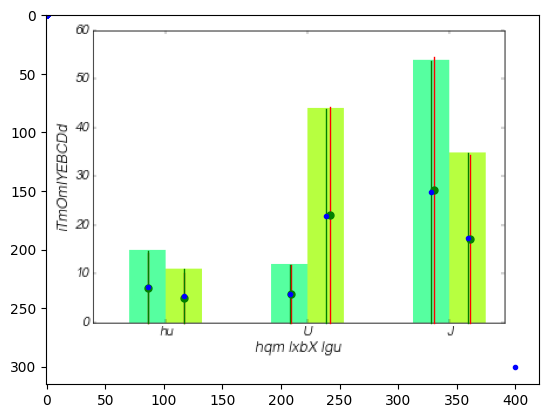

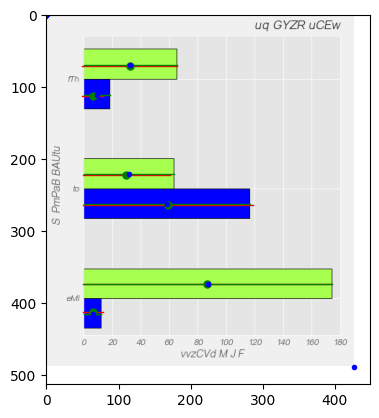

In [35]:
diretory = "result/synthetic_simple"

if diretory and not os.path.exists(diretory):
    os.makedirs(diretory)

num_image = 10

for i in range(num_image):
    image = img_name_test[i]
    target = bars_test[i]
    bar_direction = bars_direction_test[i]

    result, _ = evaluate(image)
    plot_lines_on_image(result, image, bar_direction, target, True, f"result/synthetic_simple/{i}.png")
    

## Barras simples reais

In [36]:
img_simple_names = []

for filename in os.listdir("data_challenge_simple"):
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        print(filename)
        img_simple_names.append(filename)

PMC4526302___12863_2015_249_Fig2_HTML.jpg
PMC2800115___1471-2156-10-83-2.jpg
PMC3112134___1471-2458-11-327-3.jpg
PMC3584983___1471-2458-12-776-5.jpg
PMC1508144___1471-2458-6-123-3.jpg
PMC3469004___ijph-41-72f1.jpg
PMC1543636___1471-2458-6-170-1.jpg
PMC3469035___ijph-41-56f1.jpg
PMC1318493___1471-2458-5-124-1.jpg
PMC3526493___1471-2458-12-1067-6.jpg
PMC4016520___1471-2458-13-987-4.jpg
PMC1866819___1471-2156-6-S1-S119-1.jpg
PMC3680094___1471-2156-14-45-1.jpg
PMC2764707___1471-2458-9-361-1.jpg
PMC2254396___1471-2458-8-40-2.jpg
PMC3863879___ijerph-10-05936-g004.jpg
PMC3567943___1471-2458-13-76-2.jpg
PMC3584983___1471-2458-12-776-3.jpg
PMC1584409___1471-2458-6-226-2.jpg
PMC4924073___ijerph-13-00616-g002.jpg
PMC1183531___pgen.0010017.g003.jpg
PMC1326229___1471-2350-6-43-6.jpg
PMC3166739___ijerph-08-03232f1.jpg
PMC4049506___1471-2458-14-497-1.jpg
PMC2874758___1471-2156-11-30-7.jpg
PMC3913506___CMMM2014-258627.008.jpg
PMC1868722___1471-2458-7-62-2.jpg
PMC4748744___fgene-07-00005-g0006.jpg
PMC2

In [37]:
BARS_PATH = "dataset/train_real/train_real_barbbox.idl"
IMGSIZE_PATH = "dataset/train_real/train_real_imgsize.idl"
IMG_PATH = "dataset/train_real/plots/"

all_bars = [] # target
all_bar_direction = [] # plot
all_img_name_vector = [] # source

with open(BARS_PATH, "r") as fbar, open(IMGSIZE_PATH, "r") as fsize:
    # fsize is the file that contains the image size
    # fbar is the file that contains the bar's bounding box

    for bars, imgsize in tqdm(zip(fbar, fsize)):
        bars = bars.strip() #remove \n
        imgsize = imgsize.strip() #remove \n
        bars = bars.split(SEP) # split by separator
        imgsize = imgsize.split(SEP) # split by separator
        assert bars[0] == imgsize[0], "image name not match!" # check if the image name is the same

        if bars[0] not in img_simple_names:
            continue
        
        all_img_name_vector.append(IMG_PATH + bars[0]) # add image path to the vector
        boxs = ast.literal_eval(bars[1]) # convert string to list
        imgsize = ast.literal_eval(imgsize[1]) # convert string to tuple
        one_img_bar = [START_TOKEN] # start-token 
        
        for box in boxs:
            bbox = box["bbox"]
            bar_info = get_normalized_data(bbox, imgsize)
            one_img_bar.append(bar_info)
        one_img_bar.append(END_TOKEN) # end-token
        # padding the sequence
        if len(one_img_bar) < MAX_LENGTH + 2:
            need = MAX_LENGTH + 2 - len(one_img_bar)
            for i in range(need):
                one_img_bar.append(END_TOKEN)
        
        all_bars.append(one_img_bar)
        all_bar_direction.append(imgsize[1])

bars_test, img_name_test, bars_direction_test = shuffle(all_bars, all_img_name_vector, all_bar_direction, random_state=1)

1817it [00:00, 46645.31it/s]


In [38]:
len(bars_test), len(img_name_test), len(bars_direction_test)

(48, 48, 48)

In [39]:
img_name_test[0:10]

['dataset/train_real/plots/PMC3166739___ijerph-08-03232f1.jpg',
 'dataset/train_real/plots/PMC3518824___1471-2458-12-333-1.jpg',
 'dataset/train_real/plots/PMC3799537___ijerph-10-04274-g003.jpg',
 'dataset/train_real/plots/PMC4526302___12863_2015_249_Fig2_HTML.jpg',
 'dataset/train_real/plots/PMC3033813___1471-2458-11-43-5.jpg',
 'dataset/train_real/plots/PMC3481747___ijph-40-105f4.jpg',
 'dataset/train_real/plots/PMC2800115___1471-2156-10-83-2.jpg',
 'dataset/train_real/plots/PMC4049506___1471-2458-14-497-1.jpg',
 'dataset/train_real/plots/PMC3033813___1471-2458-11-43-2.jpg',
 'dataset/train_real/plots/PMC2628942___1471-2156-9-89-2.jpg']

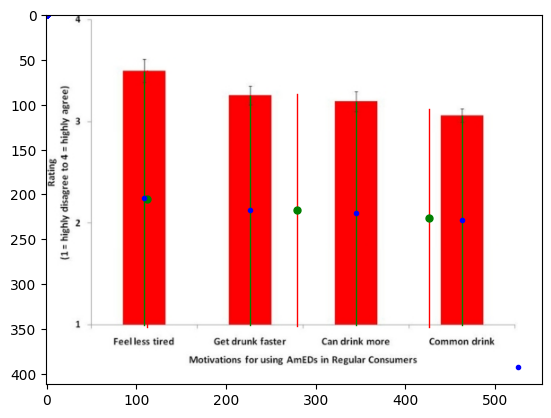

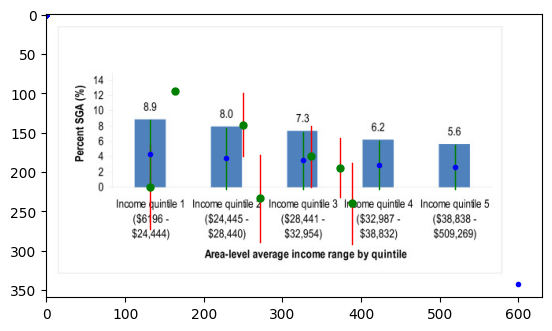

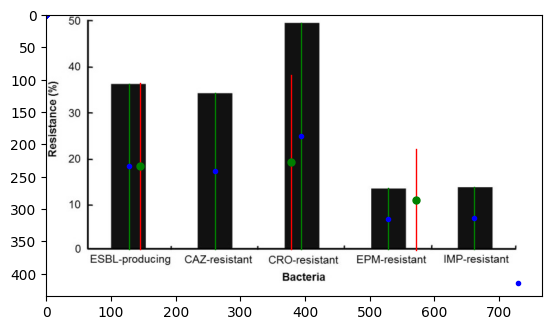

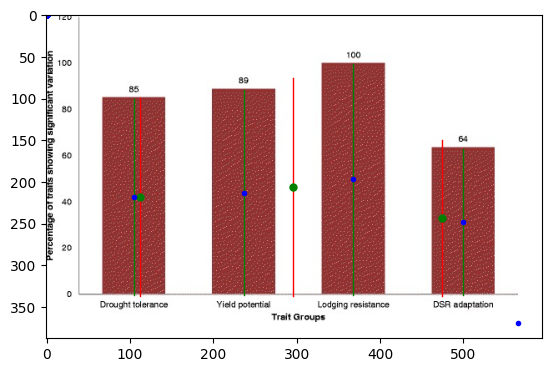

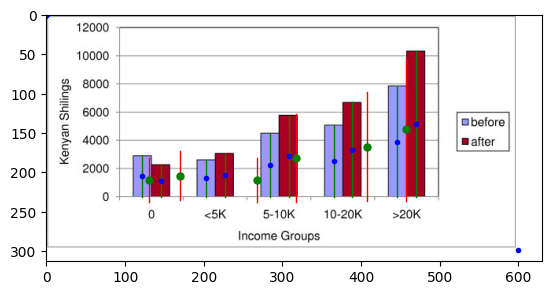

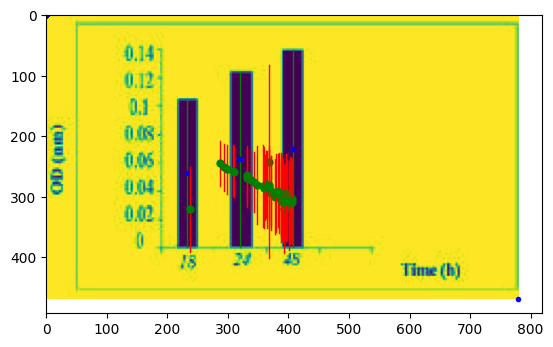

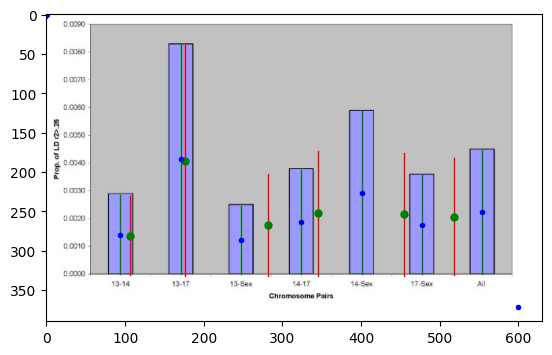

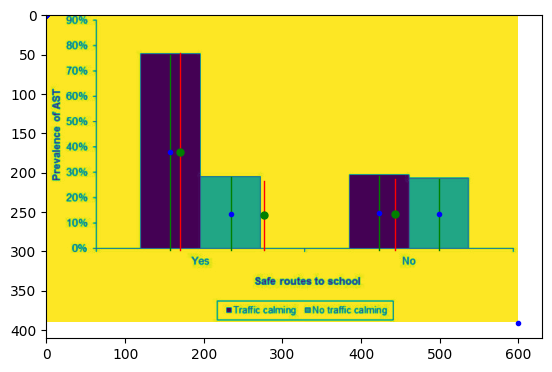

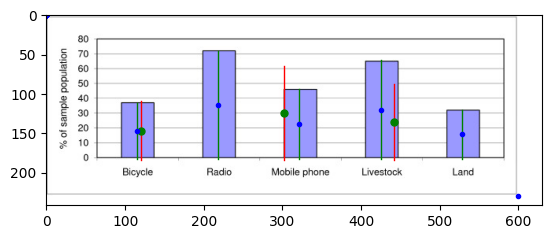

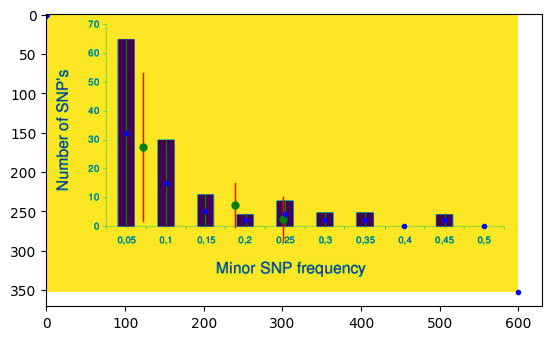

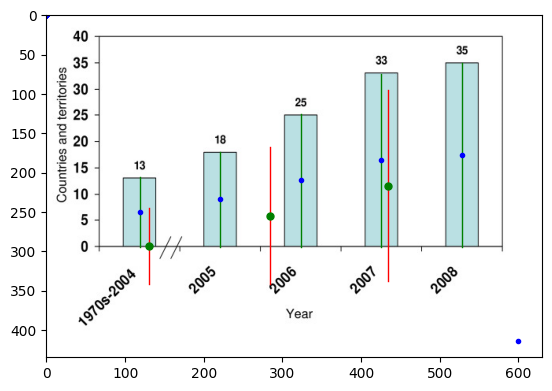

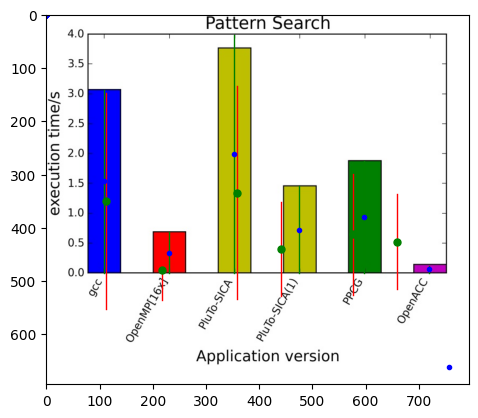

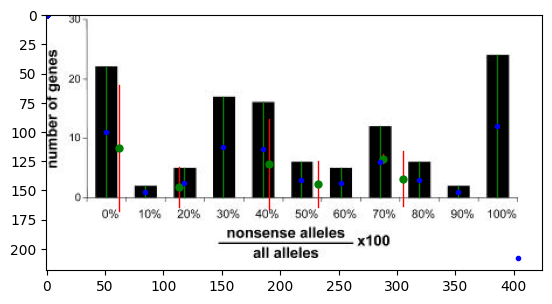

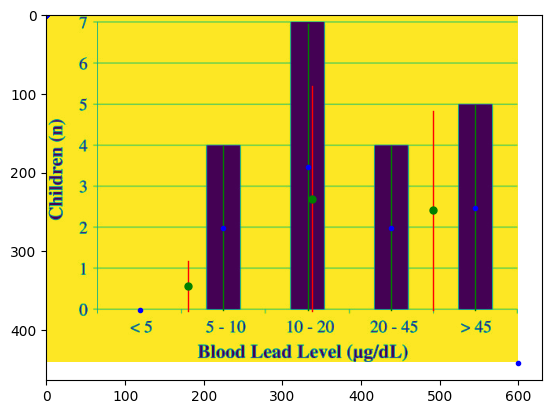

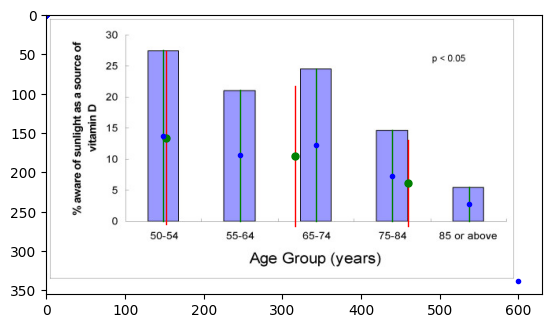

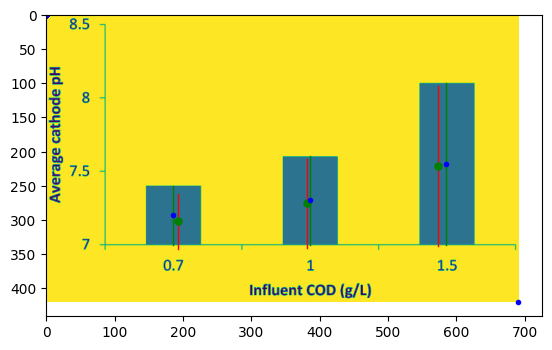

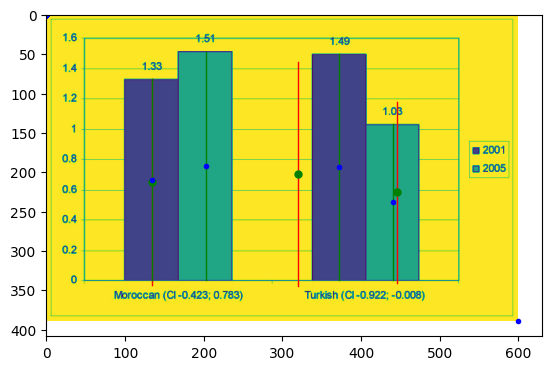

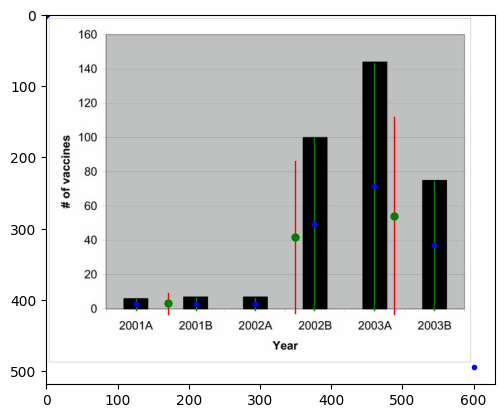

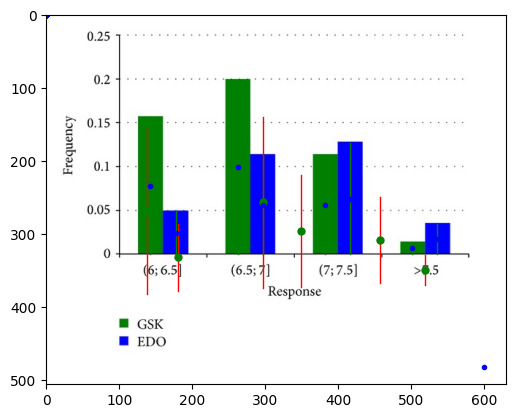

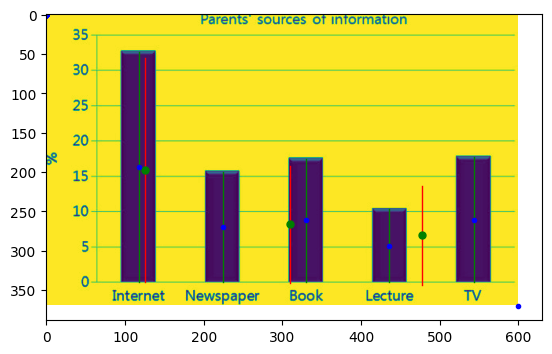

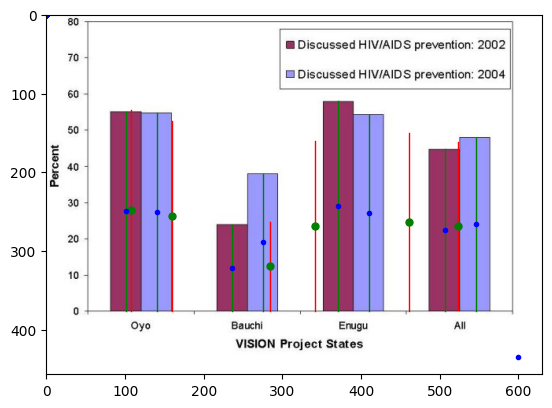

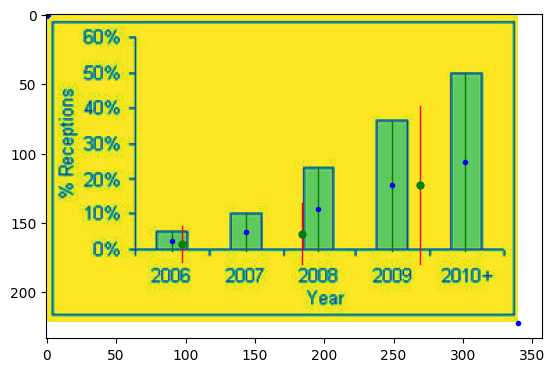

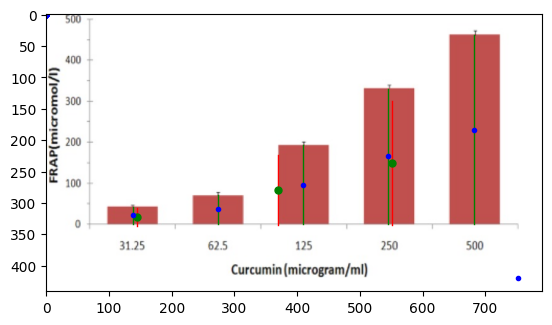

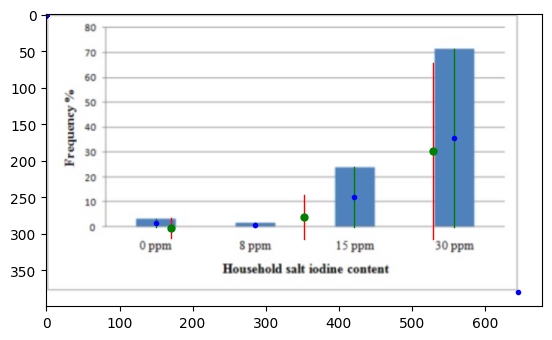

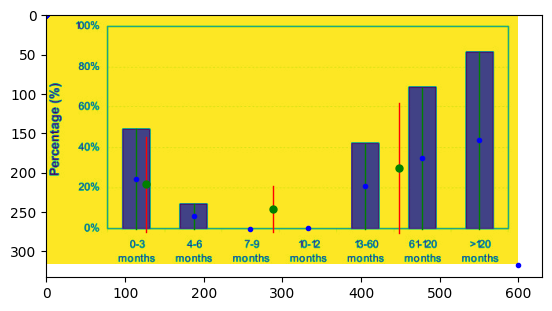

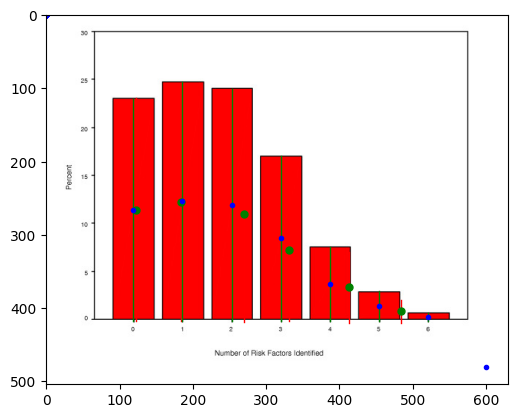

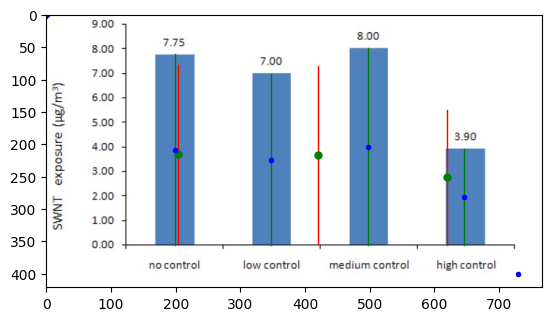

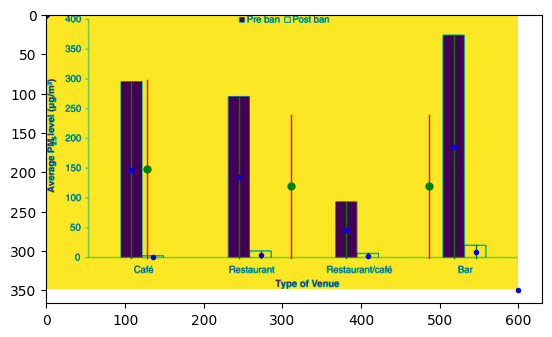

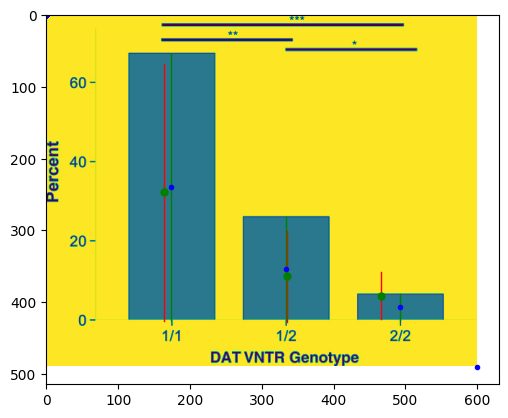

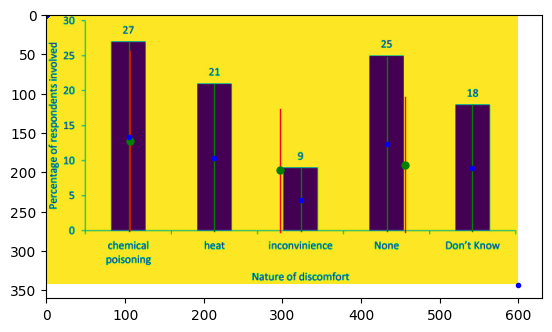

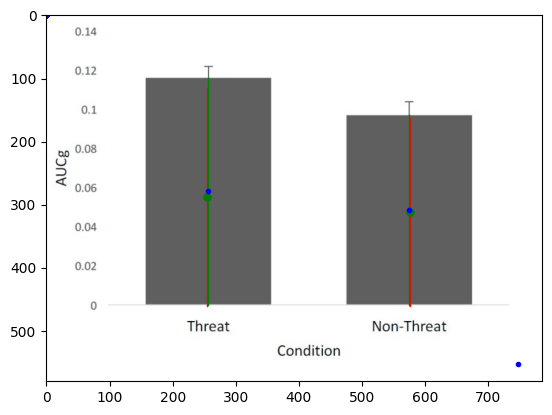

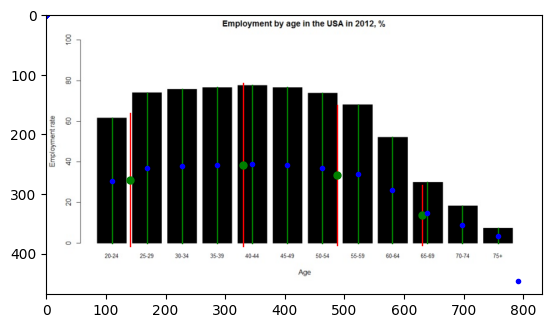

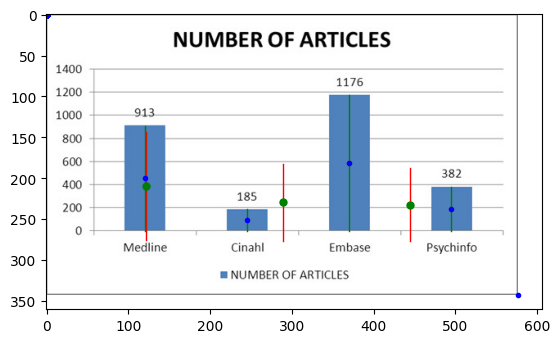

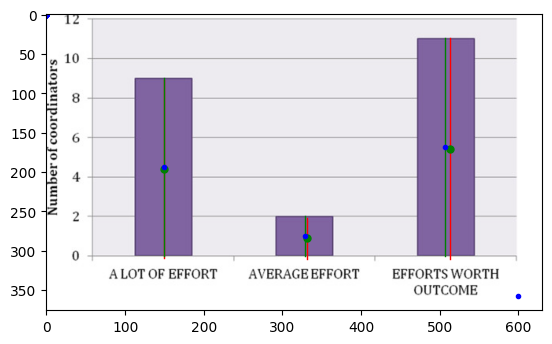

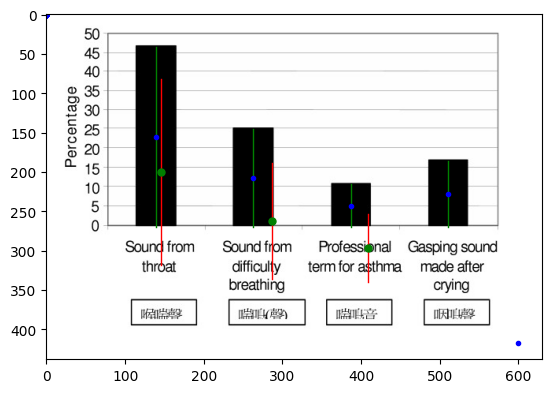

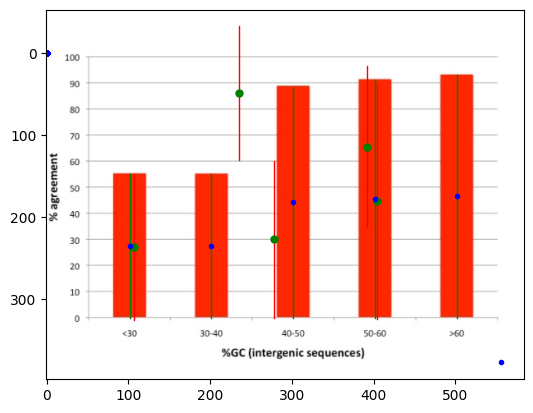

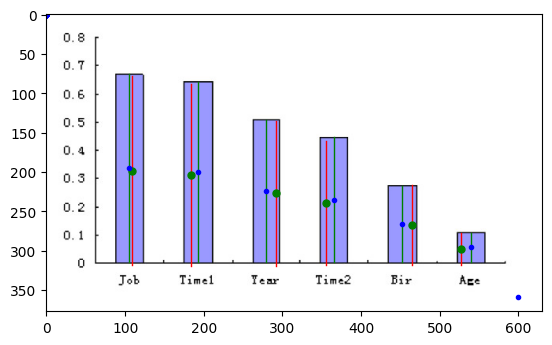

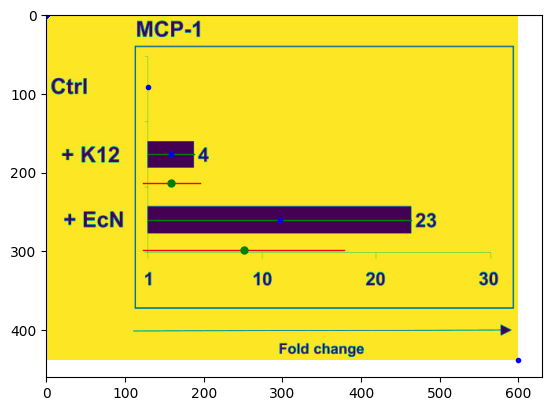

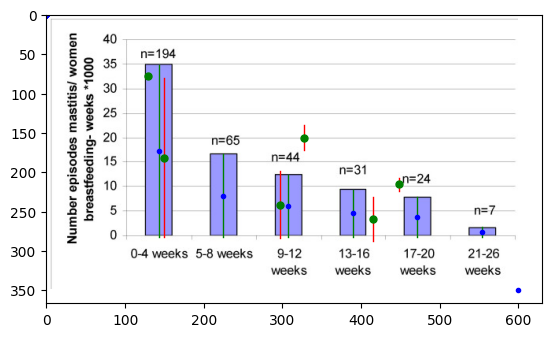

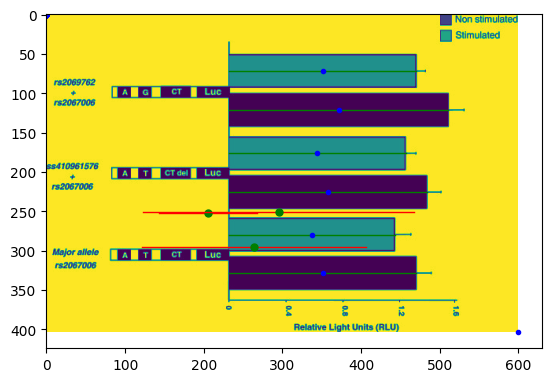

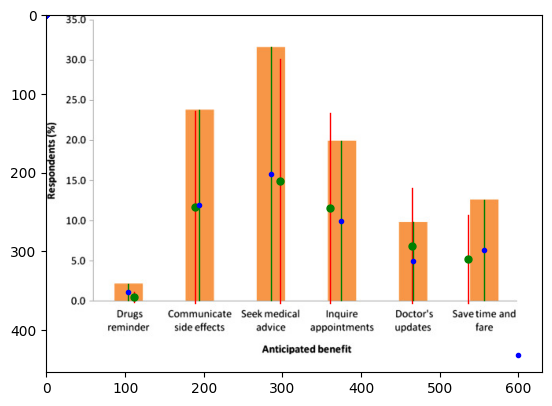

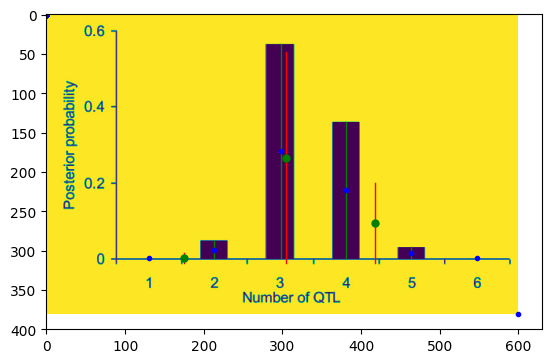

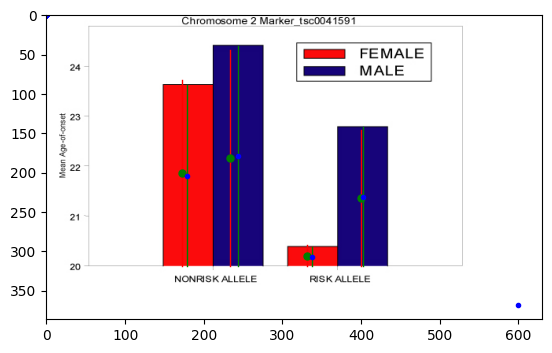

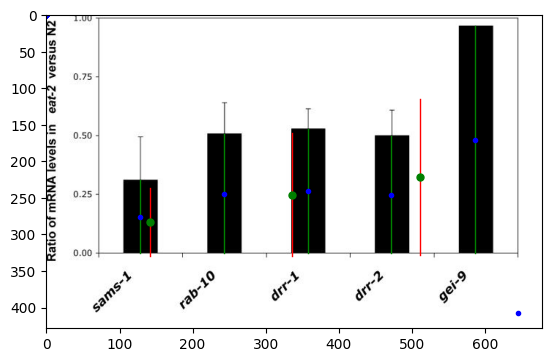

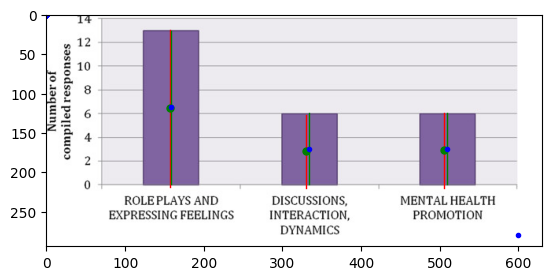

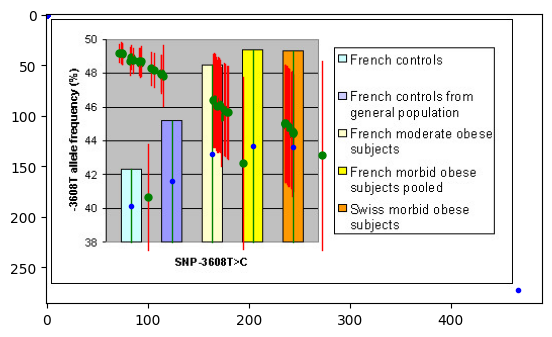

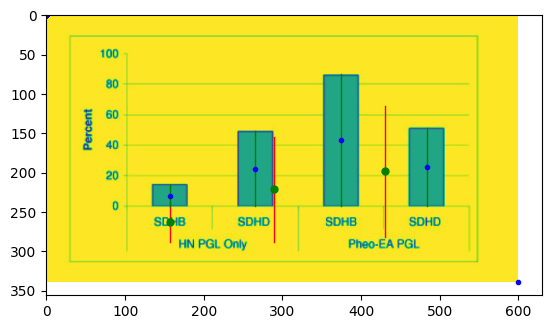

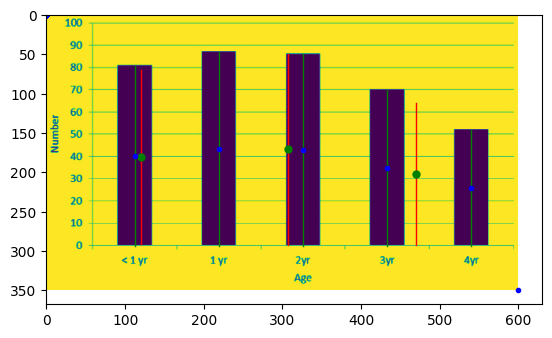

In [40]:
diretory = "result/real_simple"

if diretory and not os.path.exists(diretory):
    os.makedirs(diretory)

for i in range(len(img_name_test)):
    image = img_name_test[i]
    target = bars_test[i]
    bar_direction = bars_direction_test[i]

    result, _ = evaluate(image)
    plot_lines_on_image(result, image, bar_direction, target, True, f"result/real_simple/{i}.png")
    